In [1]:
%load_ext autoreload
%autoreload 2

In [ ]:
import torch
from common import (Gaussian, GaussianConditionalProbabilityPath,
                    GaussianMixture, LinearAlpha, SquareRootBeta,
                    imshow_density)
from matplotlib import pyplot as plt

In [ ]:

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
# Constants for the duration of our use of Gaussian conditional probability paths, to avoid polluting the namespace...
PARAMS = {
    "scale": 15.0,
    "target_scale": 10.0,
    "target_std": 1.0,
}
p_simple = Gaussian.isotropic(dim=2, std=1.0).to(device)
p_data = GaussianMixture.symmetric_2D(nmodes=5, std=PARAMS["target_std"], scale=PARAMS["target_scale"]).to(device)

/Users/yzq/Work/6.S184-lab/venv/lib/python3.9/site-packages/torch/functional.py:539: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/aten/src/ATen/native/TensorShape.cpp:3638.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


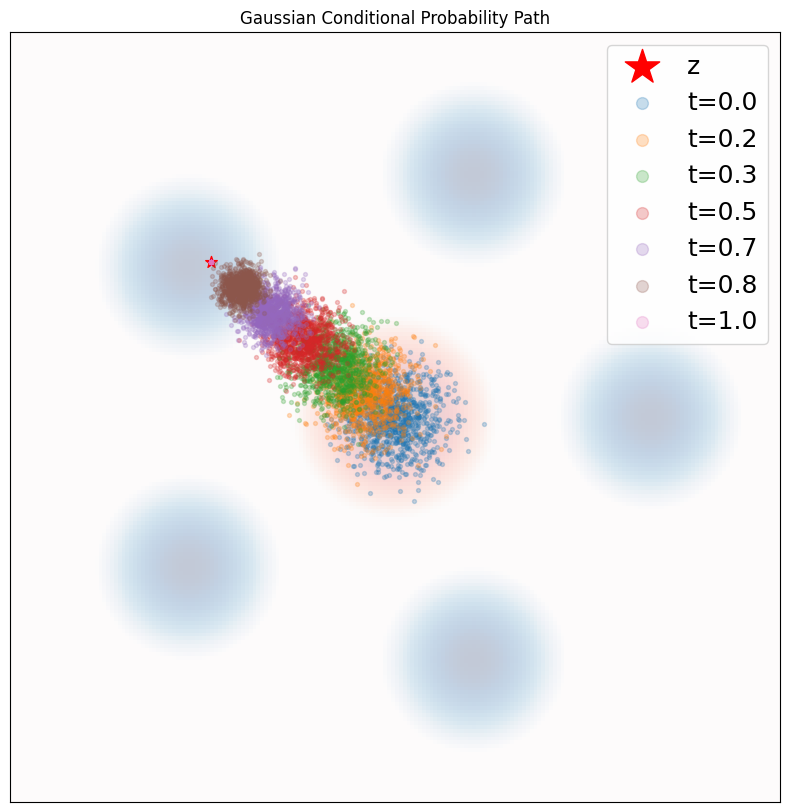

In [ ]:
# Construct conditional probability path
path = GaussianConditionalProbabilityPath(
    p_data=GaussianMixture.symmetric_2D(nmodes=5, std=PARAMS["target_std"], scale=PARAMS["target_scale"]).to(device),
    alpha=LinearAlpha(),
    beta=SquareRootBeta()
).to(device)

scale = PARAMS["scale"]
x_bounds = [-scale, scale]
y_bounds = [-scale, scale]

plt.figure(figsize=(10, 10))
plt.xlim(*x_bounds)
plt.ylim(*y_bounds)
plt.title('Gaussian Conditional Probability Path')

# Plot source and target
imshow_density(density=p_simple, x_bounds=x_bounds, y_bounds=y_bounds,
               bins=200, vmin=-10, alpha=0.25, cmap=plt.get_cmap('Reds'))
imshow_density(density=p_data, x_bounds=x_bounds, y_bounds=y_bounds,
               bins=200, vmin=-10, alpha=0.25, cmap=plt.get_cmap('Blues'))

# Sample conditioning variable z
z = path.sample_conditioning_variable(1)  # (1,2)
ts = torch.linspace(0.0, 1.0, 7).to(device)

# Plot z
plt.scatter(z[:, 0].cpu(), z[:, 1].cpu(), marker='*', color='red', s=75, label='z')
plt.xticks([])
plt.yticks([])

# Plot conditional probability path at each intermediate t
num_samples = 1000
for t in ts:
    zz = z.expand(num_samples, 2)
    tt = t.unsqueeze(0).expand(num_samples, 1)  # (samples, 1)
    samples = path.sample_conditional_path(zz, tt)  # (samples, 2)
    plt.scatter(samples[:, 0].cpu(), samples[:, 1].cpu(), alpha=0.25, s=8, label=f't={t.item():.1f}')

plt.legend(prop={'size': 18}, markerscale=3)
plt.show()

In [5]:
from common import ConditionalVectorFieldODE, EulerSimulator, record_every

100%|██████████| 999/999 [00:00<00:00, 21906.89it/s]


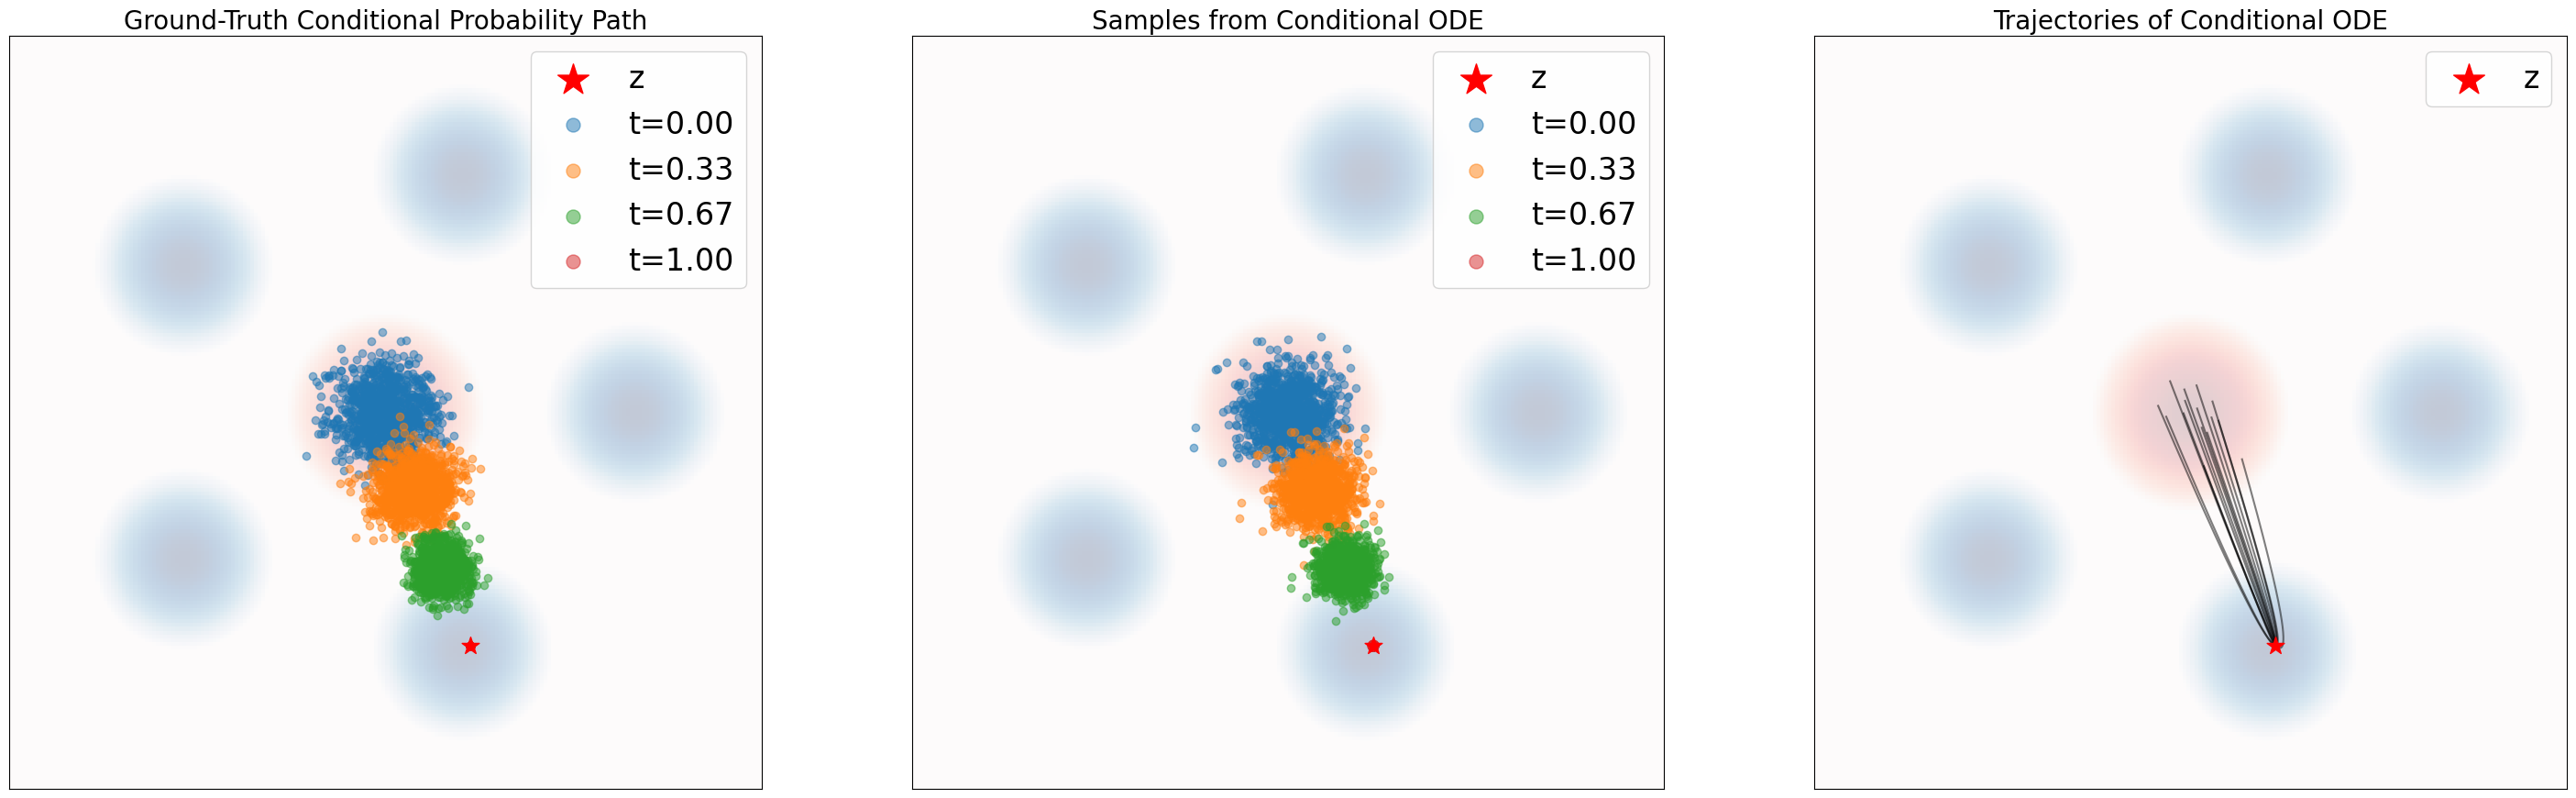

In [ ]:
# Run me for Problem 2.3!

#######################
# Change these values #
#######################

num_samples = 1000
num_timesteps = 1000
num_marginals = 3

########################
# Setup path and plot  #
########################

path = GaussianConditionalProbabilityPath(
    p_data=GaussianMixture.symmetric_2D(nmodes=5, std=PARAMS["target_std"], scale=PARAMS["target_scale"]).to(device),
    alpha=LinearAlpha(),
    beta=SquareRootBeta()
).to(device)


# Setup figure
fig, axes = plt.subplots(1, 3, figsize=(36, 12))
scale = PARAMS["scale"]
legend_size = 24
markerscale = 1.8
x_bounds = [-scale, scale]
y_bounds = [-scale, scale]

# Sample conditioning variable z
torch.cuda.manual_seed(1)
z = path.sample_conditioning_variable(1)  # (1,2)

######################################
# Graph samples from conditional ODE #
######################################
ax = axes[1]

ax.set_xlim(*x_bounds)
ax.set_ylim(*y_bounds)
ax.set_xticks([])
ax.set_yticks([])
ax.set_title('Samples from Conditional ODE', fontsize=20)
ax.scatter(z[:, 0].cpu(), z[:, 1].cpu(), marker='*', color='red', s=200, label='z', zorder=20)  # Plot z

# Plot source and target
imshow_density(density=p_simple, x_bounds=x_bounds, y_bounds=y_bounds,
               bins=200, ax=ax, vmin=-10, alpha=0.25, cmap=plt.get_cmap('Reds'))
imshow_density(density=p_data, x_bounds=x_bounds, y_bounds=y_bounds, bins=200,
               ax=ax, vmin=-10, alpha=0.25, cmap=plt.get_cmap('Blues'))


# Construct integrator and plot trajectories
sigma = 0.5  # Can't make this too high or integration is numerically unstable!
ode = ConditionalVectorFieldODE(path, z)
simulator = EulerSimulator(ode)
x0 = path.p_simple.sample(num_samples)  # (num_samples, 2)
ts = torch.linspace(0.0, 1.0, num_timesteps).view(
    1, -1, 1).expand(num_samples, -1, 1).to(device)  # (num_samples, nts, 1)
xts = simulator.simulate_with_trajectory(x0, ts)  # (bs, nts, dim)

# Extract every n-th integration step to plot
every_n = record_every(num_timesteps=num_timesteps, record_every=num_timesteps // num_marginals)
xts_every_n = xts[:, every_n, :]  # (bs, nts // n, dim)
ts_every_n = ts[0, every_n]  # (nts // n,)
for plot_idx in range(xts_every_n.shape[1]):
    tt = ts_every_n[plot_idx].item()
    ax.scatter(xts_every_n[:, plot_idx, 0].detach().cpu(), xts_every_n[:, plot_idx,
               1].detach().cpu(), marker='o', alpha=0.5, label=f't={tt:.2f}')
ax.legend(prop={'size': legend_size}, loc='upper right', markerscale=markerscale)


#########################################
# Graph Trajectories of Conditional ODE #
#########################################
ax = axes[2]

ax.set_xlim(*x_bounds)
ax.set_ylim(*y_bounds)
ax.set_xticks([])
ax.set_yticks([])
ax.set_title('Trajectories of Conditional ODE', fontsize=20)
ax.scatter(z[:, 0].cpu(), z[:, 1].cpu(), marker='*', color='red', s=200, label='z', zorder=20)  # Plot z


# Plot source and target
imshow_density(density=p_simple, x_bounds=x_bounds, y_bounds=y_bounds,
               bins=200, ax=ax, vmin=-10, alpha=0.25, cmap=plt.get_cmap('Reds'))
imshow_density(density=p_data, x_bounds=x_bounds, y_bounds=y_bounds, bins=200,
               ax=ax, vmin=-10, alpha=0.25, cmap=plt.get_cmap('Blues'))

for traj_idx in range(15):
    ax.plot(xts[traj_idx, :, 0].detach().cpu(), xts[traj_idx, :, 1].detach().cpu(), alpha=0.5, color='black')
ax.legend(prop={'size': legend_size}, loc='upper right', markerscale=markerscale)


###################################################
# Graph Ground-Truth Conditional Probability Path #
###################################################
ax = axes[0]

ax.set_xlim(*x_bounds)
ax.set_ylim(*y_bounds)
ax.set_xticks([])
ax.set_yticks([])
ax.set_title('Ground-Truth Conditional Probability Path', fontsize=20)
ax.scatter(z[:, 0].cpu(), z[:, 1].cpu(), marker='*', color='red', s=200, label='z', zorder=20)  # Plot z


for plot_idx in range(xts_every_n.shape[1]):
    tt = ts_every_n[plot_idx].unsqueeze(0).expand(num_samples, 1)
    zz = z.expand(num_samples, 2)
    marginal_samples = path.sample_conditional_path(zz, tt)
    ax.scatter(marginal_samples[:, 0].detach().cpu(), marginal_samples[:, 1].detach().cpu(),
               marker='o', alpha=0.5, label=f't={tt[0,0].item():.2f}')

# Plot source and target
imshow_density(density=p_simple, x_bounds=x_bounds, y_bounds=y_bounds,
               bins=200, ax=ax, vmin=-10, alpha=0.25, cmap=plt.get_cmap('Reds'))
imshow_density(density=p_data, x_bounds=x_bounds, y_bounds=y_bounds, bins=200,
               ax=ax, vmin=-10, alpha=0.25, cmap=plt.get_cmap('Blues'))
ax.legend(prop={'size': legend_size}, loc='upper right', markerscale=markerscale)

plt.show()

In [7]:
from common import ConditionalVectorFieldSDE, EulerMaruyamaSimulator

100%|██████████| 999/999 [00:00<00:00, 11587.56it/s]


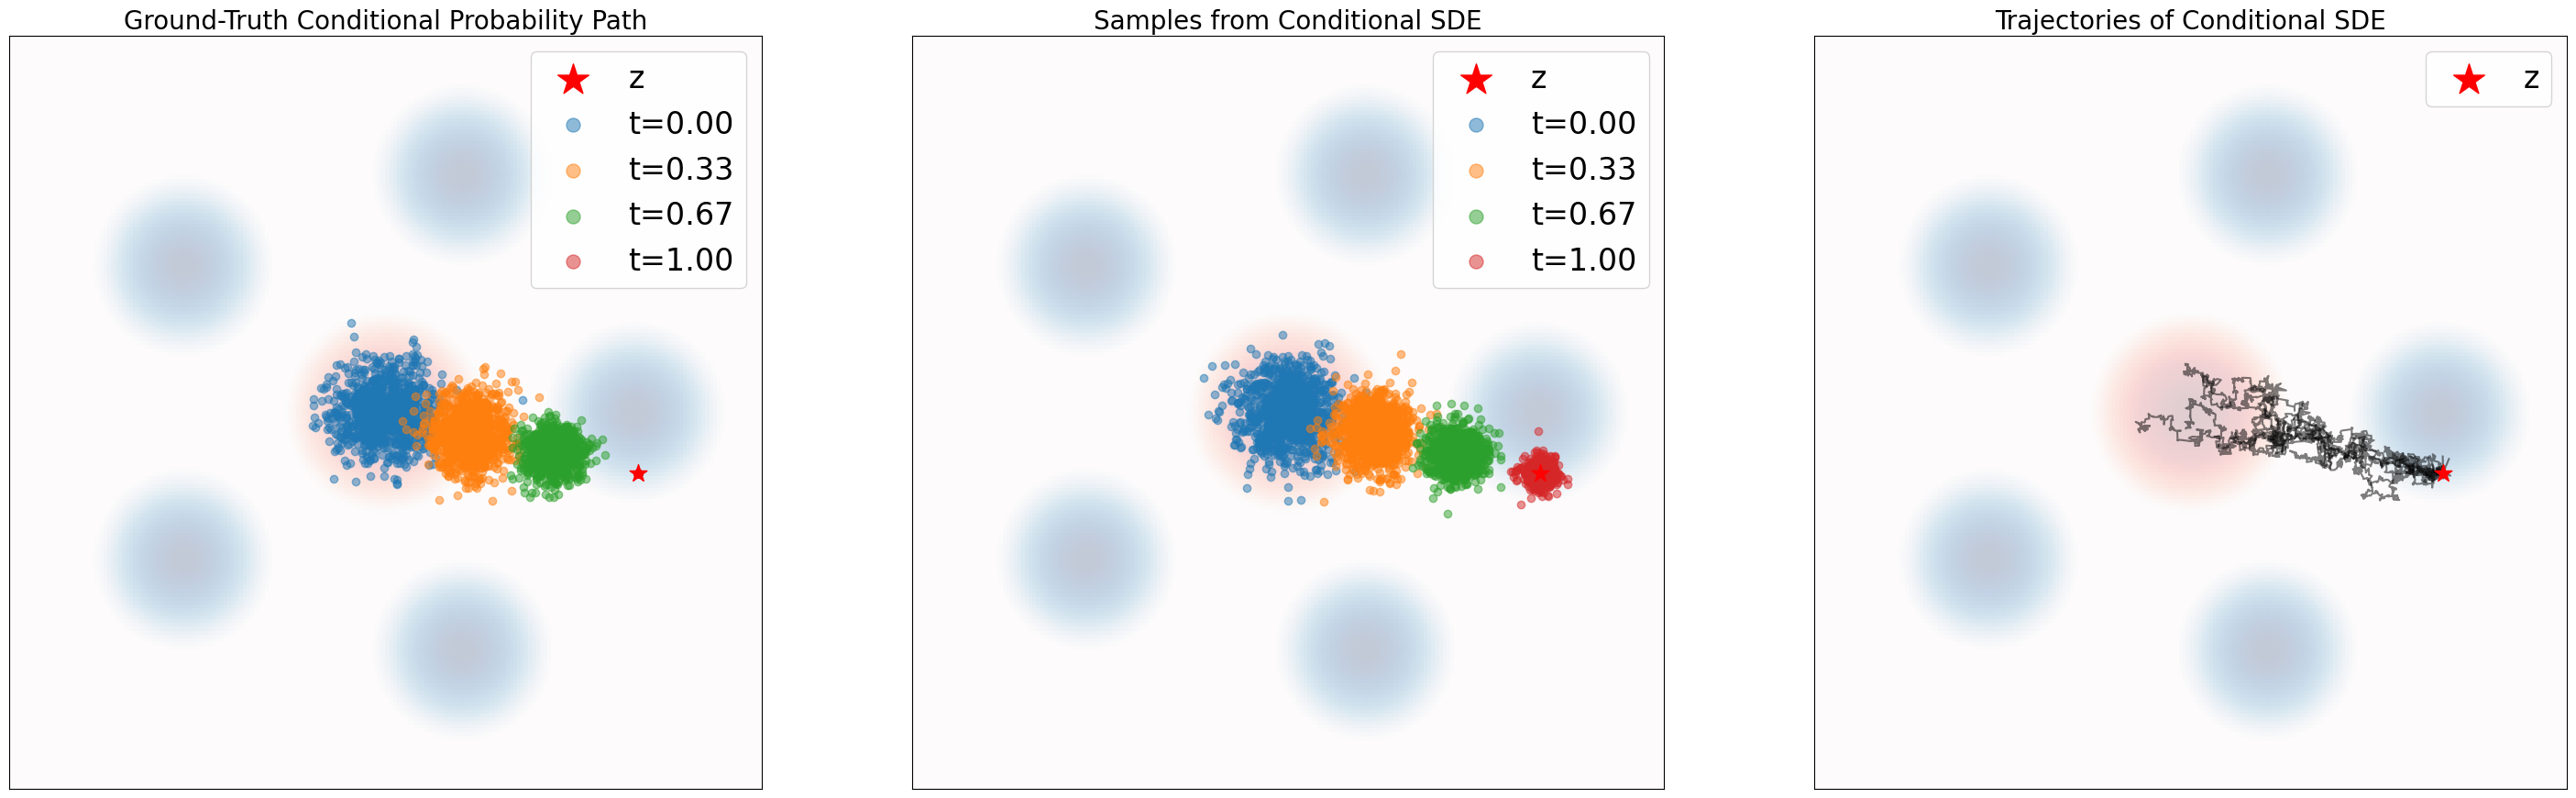

In [11]:
# Run me for Problem 2.3!

#######################
# Change these values #
#######################


num_samples = 1000
num_timesteps = 1000
num_marginals = 3
sigma = 2.5

########################
# Setup path and plot  #
########################

path = GaussianConditionalProbabilityPath(
    p_data = GaussianMixture.symmetric_2D(nmodes=5, std=PARAMS["target_std"], scale=PARAMS["target_scale"]).to(device),
    alpha = LinearAlpha(),
    beta = SquareRootBeta()
).to(device)


# Setup figure
fig, axes = plt.subplots(1,3, figsize=(36, 12))
scale = PARAMS["scale"]
x_bounds = [-scale,scale]
y_bounds = [-scale,scale]
legend_size = 24
markerscale = 1.8

# Sample conditioning variable z
torch.cuda.manual_seed(1)
z = path.sample_conditioning_variable(1) # (1,2)

######################################
# Graph Samples from Conditional SDE #
######################################
ax = axes[1]

ax.set_xlim(*x_bounds)
ax.set_ylim(*y_bounds)
ax.set_xticks([])
ax.set_yticks([])
ax.set_title('Samples from Conditional SDE', fontsize=20)
ax.scatter(z[:,0].cpu(), z[:,1].cpu(), marker='*', color='red', s=200, label='z',zorder=20) # Plot z

# Plot source and target
imshow_density(density=p_simple, x_bounds=x_bounds, y_bounds=y_bounds, bins=200, ax=ax, vmin=-10, alpha=0.25, cmap=plt.get_cmap('Reds'))
imshow_density(density=p_data, x_bounds=x_bounds, y_bounds=y_bounds, bins=200, ax=ax, vmin=-10, alpha=0.25, cmap=plt.get_cmap('Blues'))


# Construct integrator and plot trajectories
sde = ConditionalVectorFieldSDE(path, z, sigma)
simulator = EulerMaruyamaSimulator(sde)
x0 = path.p_simple.sample(num_samples) # (num_samples, 2)
ts = torch.linspace(0.0, 1.0, num_timesteps).view(1,-1,1).expand(num_samples,-1,1).to(device) # (num_samples, nts, 1)
xts = simulator.simulate_with_trajectory(x0, ts) # (bs, nts, dim)

# Extract every n-th integration step to plot
every_n = record_every(num_timesteps=num_timesteps, record_every=num_timesteps // num_marginals)
xts_every_n = xts[:,every_n,:] # (bs, nts // n, dim)
ts_every_n = ts[0,every_n] # (nts // n,)
for plot_idx in range(xts_every_n.shape[1]):
    tt = ts_every_n[plot_idx].item()
    ax.scatter(xts_every_n[:,plot_idx,0].detach().cpu(), xts_every_n[:,plot_idx,1].detach().cpu(), marker='o', alpha=0.5, label=f't={tt:.2f}')
ax.legend(prop={'size': legend_size}, loc='upper right', markerscale=markerscale)


##########################################
# Graph Trajectories of Conditional SDE  #
##########################################
ax = axes[2]

ax.set_xlim(*x_bounds)
ax.set_ylim(*y_bounds)
ax.set_xticks([])
ax.set_yticks([])
ax.set_title('Trajectories of Conditional SDE', fontsize=20)
ax.scatter(z[:,0].cpu(), z[:,1].cpu(), marker='*', color='red', s=200, label='z',zorder=20) # Plot z


# Plot source and target
imshow_density(density=p_simple, x_bounds=x_bounds, y_bounds=y_bounds, bins=200, ax=ax, vmin=-10, alpha=0.25, cmap=plt.get_cmap('Reds'))
imshow_density(density=p_data, x_bounds=x_bounds, y_bounds=y_bounds, bins=200, ax=ax, vmin=-10, alpha=0.25, cmap=plt.get_cmap('Blues'))

for traj_idx in range(5):
    ax.plot(xts[traj_idx,:,0].detach().cpu(), xts[traj_idx,:,1].detach().cpu(), alpha=0.5, color='black')
ax.legend(prop={'size': legend_size}, loc='upper right', markerscale=markerscale)


###################################################
# Graph Ground-Truth Conditional Probability Path #
###################################################
ax = axes[0]

ax.set_xlim(*x_bounds)
ax.set_ylim(*y_bounds)
ax.set_xticks([])
ax.set_yticks([])
ax.set_title('Ground-Truth Conditional Probability Path', fontsize=20)
ax.scatter(z[:,0].cpu(), z[:,1].cpu(), marker='*', color='red', s=200, label='z',zorder=20) # Plot z


for plot_idx in range(xts_every_n.shape[1]):
    tt = ts_every_n[plot_idx].unsqueeze(0).expand(num_samples, 1)
    zz = z.expand(num_samples, 2)
    marginal_samples = path.sample_conditional_path(zz, tt)
    ax.scatter(marginal_samples[:,0].detach().cpu(), marginal_samples[:,1].detach().cpu(), marker='o', alpha=0.5, label=f't={tt[0,0].item():.2f}')

# Plot source and target
imshow_density(density=p_simple, x_bounds=x_bounds, y_bounds=y_bounds, bins=200, ax=ax, vmin=-10, alpha=0.25, cmap=plt.get_cmap('Reds'))
imshow_density(density=p_data, x_bounds=x_bounds, y_bounds=y_bounds, bins=200, ax=ax, vmin=-10, alpha=0.25, cmap=plt.get_cmap('Blues'))
ax.legend(prop={'size': legend_size}, loc='upper right', markerscale=markerscale)

plt.show()